# 2026 MCM Problem C: Analysis & Solution Pipeline

## 1. Introduction & Overview
This notebook documents the computational framework used to analyze the dynamics of the *Dancing with the Stars* voting system. Our approach integrates rigorous data preprocessing, Bayesian inverse optimization, and statistical modeling to reconstruct hidden fan voting patterns and evaluate their impact on competition outcomes.

### Core Components:
1.  **Data Ingestion**: Transforming raw season data into a standardized longitudinal format.
2.  **Latent Variable Reconstruction**: Using MCMC to infer judging/fan weights from elimination outcomes.
3.  **Statistical Inference**: Quantifying the impact of demographics, partnerships, and scores on survival.
4.  **Policy Simulation**: Counterfactual analysis of alternative voting rules.

---
## 2. Data Loading and Preprocessing
We begin by standardizing the heterogeneous weekly score data into a unified temporal structure.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
import re
from typing import Iterable, List, Optional, Tuple, Dict
import statsmodels.api as sm
import sklearn.preprocessing as preprocessing
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- PLOTTING STYLE SETUP ---
# Set a modern, clean theme for all plots
sns.set_theme(style="whitegrid", context="notebook", font_scale=1.1)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 140
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.unicode_minus'] = False # For negative numbers
plt.rcParams['lines.linewidth'] = 2.0

# --- DATA PREPROCESSING & STANDARDIZATION ---

WEEK_SCORE_PATTERN = re.compile(r"^week(\d+)_judge(\d+)_score$")

def load_raw_data(file_path: str) -> pd.DataFrame:
    """Load the raw dataset."""
    return pd.read_csv(file_path)

def parse_elimination_week(result_str: object) -> Optional[object]:
    """
    Parses the elimination week from the result string.
    Returns the week number (int) or 'Final' (str).
    """
    if pd.isna(result_str):
        return None
    text = str(result_str)
    match = re.search(r"Eliminated Week (\d+)", text)
    if match:
        return int(match.group(1))
    if "Place" in text:
        return "Final"
    return None

def _week_numbers_from_columns(columns: Iterable[str]) -> List[int]:
    """Extracts all unique week numbers present in the column headers."""
    week_numbers = set()
    for col in columns:
        match = WEEK_SCORE_PATTERN.match(col)
        if match:
            week_numbers.add(int(match.group(1)))
    return sorted(week_numbers)

def _score_columns_for_week(columns: Iterable[str], week: int) -> List[str]:
    """Returns column names corresponding to a specific week."""
    prefix = f"week{week}_"
    return [c for c in columns if c.startswith(prefix) and c.endswith("_score")]

def _sum_week_scores(row: pd.Series, score_cols: List[str]) -> Optional[float]:
    """Calculates the aggregate judge score for a given week."""
    if not score_cols:
        return None
    values = pd.to_numeric(row[score_cols], errors="coerce")
    if values.isna().all():
        return None
    return float(values.fillna(0).sum())

def compute_weekly_scores(df: pd.DataFrame) -> pd.DataFrame:
    """
    Transforms the raw wide-format data into a standard long-format temporal dataset.
    
    Returns:
        pd.DataFrame: Contains [Season, Week, Contestant, JudgeScore, EliminatedThisWeek, Result, Placement]
    """
    week_numbers = _week_numbers_from_columns(df.columns)
    records = []

    for _, row in df.iterrows():
        contestant = row["celebrity_name"]
        season = row["season"]
        elim_week = parse_elimination_week(row["results"])

        for week in week_numbers:
            score_cols = _score_columns_for_week(df.columns, week)
            total_score = _sum_week_scores(row, score_cols)
            
            # Filter out weeks where the contestant did not compete
            if total_score is None or total_score <= 0:
                continue

            records.append(
                {
                    "Season": int(season),
                    "Week": int(week),
                    "Contestant": contestant,
                    "JudgeScore": total_score,
                    "EliminatedThisWeek": (elim_week == week),
                    "Result": row.get("results", None),
                    "Placement": row.get("placement", None),
                }
            )

    return pd.DataFrame(records)

# Execute Data Ingestion
file_path = '2026_MCM_Problem_C_Data.csv'
df = load_raw_data(file_path)
df_weekly = compute_weekly_scores(df)

print(f"Data Loaded: {len(df_weekly)} weekly observations.")
print(f"Temporal Range: Season {df_weekly['Season'].min()} to {df_weekly['Season'].max()}.")
display(df_weekly.head(3))

Data Loaded: 2777 weekly observations.
Temporal Range: Season 1 to 34.


,Season,Week,Contestant,JudgeScore,EliminatedThisWeek,Result,Placement
0,1,1,John O'Hurley,20.0,False,2nd Place,2
1,1,2,John O'Hurley,26.0,False,2nd Place,2
2,1,3,John O'Hurley,24.0,False,2nd Place,2


## 3. Mathematical Formalization

To reconstruct the latent fan preferences, we model the two distinct voting mechanisms employed historically:

### Mechanism A: Rank-Based Aggregation
*Used in Seasons 1-2, 28-Present*
*   **Judge Component**: Rank of raw judge scores $R_{J,i}$ (1 = Best).
*   **Fan Component**: Rank of fan votes $R_{F,i}$ (1 = Most Votes).
*   **Decision Rule**: Eliminate $k = \arg\max_i (R_{J,i} + R_{F,i})$. Ties broken by Fan Rank.

### Mechanism B: Probability-Based Aggregation
*Used in Seasons 3-27*
*   **Judge Component**: Share of total points $P_{J,i} = \frac{S_{j,i}}{\sum S_j}$.
*   **Fan Component**: Share of total votes $P_{F,i}$ (Latent).
*   **Decision Rule**: Eliminate $k = \arg\min_i (P_{J,i} + P_{F,i})$.

*Note: In "Bottom Two" scenarios, we assume the eliminated contestant had the lowest aggregate score.*

In [13]:
def calculate_ranks(scores, ascending=False):
    """
    Computes ordinal ranks for a score vector.
    
    Parameters:
        scores (array-like): Quantitative scores.
        ascending (bool): If False (default), higher scores receive better (lower) ranks.
                          Used for Judge Scores where 30 is Rank 1.
    
    Returns:
        np.array: Array of ranks using 'min' method for ties.
    """
    if not ascending:
        # Rank negative values so highest score gets rank 1
        return rankdata([-s for s in scores], method='min')
    return rankdata(scores, method='min')

def calculate_rank_elimination(judge_scores, fan_ranks):
    """
    Determines the eliminated contestant under the Rank-Based Rule.
    
    Logic:
        1. Convert Judge Scores to Ranks (1 = Best).
        2. Fan Ranks are provided directly (1 = Best).
        3. Eliminate contestant with Highest Sum of Ranks.
        4. Tie-Breaker: Contestant with worse Fan Rank is eliminated.
    
    Parameters:
        judge_scores (array-like): Raw judge scores.
        fan_ranks (array-like): Simulated fan ranks.
        
    Returns:
        int: Index of the eliminated contestant.
    """
    j_ranks = calculate_ranks(judge_scores)
    total_ranks = j_ranks + fan_ranks
    
    # Store tuples of (TotalRank, FanRank, Index)
    # Sort Descending: Highest Total sum = Worst performance
    combined = []
    for i in range(len(total_ranks)):
        combined.append((total_ranks[i], fan_ranks[i], i))
        
    combined.sort(key=lambda x: (x[0], x[1]), reverse=True)
    
    return combined[0][2]

def calculate_percent_elimination(judge_scores, fan_percents):
    """
    Determines the eliminated contestant under the Percentage-Based Rule.
    
    Logic:
        1. Convert Judge Scores to Percentage of Total Points.
        2. Add Fan Vote Percentages.
        3. Eliminate contestant with Lowest Total Percentage.
        
    Parameters:
        judge_scores (array-like): Raw judge scores.
        fan_percents (array-like): Fan vote shares (summing to 1.0).
        
    Returns:
        int: Index of the eliminated contestant.
    """
    total_judge = sum(judge_scores)
    # Edge case handling for zero sum
    if total_judge == 0: 
        j_percents = np.zeros(len(judge_scores))
    else:
        j_percents = np.array(judge_scores) / total_judge
        
    total_score = j_percents + fan_percents
    
    # Sort Ascending: Lowest Total Score = Eliminated
    # Tie-Breaker: Lower Fan Vote is prioritized for elimination
    combined = []
    for i in range(len(total_score)):
        combined.append((total_score[i], fan_percents[i], i))
    
    combined.sort(key=lambda x: (x[0], x[1]))
    
    return combined[0][2]

## 3. Stochastic Inverse Optimization via Bayesian Inference

We employ a **Bayesian Markov Chain Monte Carlo (MCMC)** approach to estimate the posterior distribution of latent fan support, conditioned on observed elimination outcomes.

**Methodology**
We model the unknown fan support vector $\mathbf{P}_F$ with a Dirichlet prior:
$$ \mathbf{P}_F \sim \text{Dirichlet}(\boldsymbol{\alpha}) $$

where $\boldsymbol{\alpha}$ encodes prior belief (centered around equal popularity, with inertia from previous weeks).

**Algorithm**
1. **Prior Construction**: Define $\boldsymbol{\alpha}_t$ from the posterior mean of week $t-1$.
2. **Sampling**: Draw **$N=50{,}000$** samples from $\text{Dirichlet}(\boldsymbol{\alpha}_t)$.
3. **Validation**: Accept samples whose simulated elimination matches the observed result $E_{obs}$.
4. **Posterior Estimation**: Use accepted samples to estimate fan support and uncertainty.

**Optimization Note**: Increasing $N$ reduces Monte Carlo error at rate $\propto 1/\sqrt{N}$ and improves stability in rank-based seasons.

In [14]:
def get_voting_mode(season_num: int) -> str:
    """Returns 'rank' or 'percent' based on historical rules."""
    if season_num <= 2 or season_num >= 28:
        return 'rank'
    return 'percent'

def simulate_fan_votes(season_num: int, week_num: int, num_samples: int = 50000, prior_support: dict = None):
    """
    Performs Bayesian inference to estimate fan votes consistent with the observed elimination.

    Parameters:
        season_num (int): Target season.
        week_num (int): Target week.
        num_samples (int): Number of Monte Carlo iterations (default: 50,000).
        prior_support (dict): Posterior means from previous week (inertia).

    Returns:
        samples (np.array): Matrix of accepted fan vote vectors.
        names (np.array): Array of contestant names.
        mode (str): Voting mechanism used ('rank' or 'percent').
    """
    subset = df_weekly[(df_weekly['Season'] == season_num) & (df_weekly['Week'] == week_num)].copy()
    if subset.empty:
        return None, None, None

    # Detect observed elimination
    eliminated_rows = subset[subset['EliminatedThisWeek'] == True]
    has_elimination = not eliminated_rows.empty

    contestants = subset['Contestant'].values
    judge_scores = subset['JudgeScore'].values

    # Map eliminated names to indices
    elim_indices = []
    if has_elimination:
        for elim_name in eliminated_rows['Contestant'].values:
            idx = np.where(contestants == elim_name)[0]
            if len(idx) > 0:
                elim_indices.append(idx[0])

    num_c = len(contestants)
    valid_fan_votes = []
    mode = get_voting_mode(season_num)

    # Informative priors (hyperparameters)
    base_alpha = 5.0
    inertia_weight = 100.0

    alphas = []
    for name in contestants:
        if prior_support and name in prior_support:
            prev = prior_support[name]
            if mode == 'rank' and prev >= 1.0:
                weight = (num_c + 1 - prev)
                alphas.append(base_alpha + (5.0 * weight))
            else:
                alphas.append(base_alpha + (inertia_weight * prev))
        else:
            alphas.append(base_alpha + (inertia_weight * (1.0 / num_c)))

    alphas = np.array(alphas)

    # Monte Carlo sampling
    try:
        raw_samples = np.random.dirichlet(alphas, num_samples)
    except Exception:
        raw_samples = np.random.dirichlet(np.ones(num_c) * base_alpha, num_samples)

    for fan_pcts in raw_samples:
        if mode == 'rank':
            fan_ranks = rankdata([-p for p in fan_pcts], method='min')
            if has_elimination:
                loser_idx = calculate_rank_elimination(judge_scores, fan_ranks)
                if loser_idx in elim_indices:
                    valid_fan_votes.append(fan_ranks)
            else:
                valid_fan_votes.append(fan_ranks)
        else:
            if has_elimination:
                loser_idx = calculate_percent_elimination(judge_scores, fan_pcts)
                if loser_idx in elim_indices:
                    valid_fan_votes.append(fan_pcts)
            else:
                valid_fan_votes.append(fan_pcts)

    if len(valid_fan_votes) == 0:
        return None, contestants, mode

    return np.array(valid_fan_votes), contestants, mode

print("Bayesian Inference Model initialized.")

Bayesian Inference Model initialized.


## 5. Global Parameter Estimation & Historical Reconstruction

Having validated the Bayesian inference engine on singular cases, we now scale the process to reconstruction of the latent fan support trajectories for the entire historical dataset.

**Procedure:**
*   **Sequential Bayesian Updating**: For each season, we initialize a flat prior. As weeks progress, the posterior mean of week $t$ informs the prior for week $t+1$ (incorporating an "inertia" hyperparameter to model popularity stability).
*   **Output generation**: This yields a longitudinal dataset of `Est_Fan_Support` and `Est_Fan_Uncertainty` for every contestant-week tuple.

*Computation Note: This involves executing the MCMC sampling routine for every elimination event across all seasons.*

In [15]:
# --- Main Historical Reconstruction Loop (Sequential) ---

full_history_stats = []
seasons = sorted(df_weekly['Season'].unique())

print(f"Starting reconstruction for {len(seasons)} seasons...")

# SKIP SIMULATION IF FILE EXISTS TO SAVE TIME
import os
if os.path.exists('estimated_fan_votes.csv'):
    print("Found existing 'estimated_fan_votes.csv'. Loading data...")
    df_estimated_full = pd.read_csv('estimated_fan_votes.csv')
else:
    print("No existing data found. Running simulation (this may take a long time)...")
    for s in seasons:
        weeks = sorted(df_weekly[df_weekly['Season'] == s]['Week'].unique())
        current_season_priors = {}

        for w in weeks:
            # Increased samples to 50,000 for higher-fidelity reconstruction
            feasible, names, mode = simulate_fan_votes(s, w, num_samples=50000, prior_support=current_season_priors)

            if feasible is not None and len(feasible) > 0:
                means = feasible.mean(axis=0)
                stds = feasible.std(axis=0)

                for i, name in enumerate(names):
                    current_season_priors[name] = means[i]

                    full_history_stats.append({
                        'Season': s,
                        'Week': w,
                        'Contestant': name,
                        'Judge_Score': df_weekly[(df_weekly['Season'] == s) & (df_weekly['Week'] == w) & (df_weekly['Contestant'] == name)]['JudgeScore'].values[0],
                        'Est_Fan_Support': means[i],
                        'Est_Fan_Uncertainty': stds[i],
                        'Voting_Mode': mode
                    })

    # Save Results
    if full_history_stats:
        df_estimated_full = pd.DataFrame(full_history_stats)
        df_estimated_full.to_csv('estimated_fan_votes.csv', index=False)
        print(f"Completed. Generated {len(df_estimated_full)} records.")
        print("Saved to 'estimated_fan_votes.csv'.")

# Merge for analysis
df_full_analysis = pd.merge(df_weekly, df_estimated_full, on=['Season', 'Week', 'Contestant'], how='left')
display(df_estimated_full.head())

Starting reconstruction for 34 seasons...
Found existing 'estimated_fan_votes.csv'. Loading data...


,Season,Week,Contestant,Judge_Score,Est_Fan_Support,Est_Fan_Uncertainty,Voting_Mode
0,1,1,John O'Hurley,20.0,3.50426,1.707859,rank
1,1,1,Kelly Monaco,13.0,3.49960,1.703690,rank
2,1,1,Evander Holyfield,18.0,3.49840,1.710683,rank
3,1,1,Rachel Hunter,20.0,3.49730,1.708471,rank
4,1,1,Joey McIntyre,20.0,3.50130,1.707829,rank


## 6. Model Diagnostics and Validation

We assesses the reliability of the reconstructed latent variables through two metrics:

### 6.1 Posterior Variance Analysis
The standard deviation of the posterior distribution (`Est_Fan_Uncertainty`) quantifies the **identifiability** of the fan vote.
*   **High Variance**: Indicates the solution space is broad; multiple fan vote configurations could explain the observed elimination (low judges' signal-to-noise ratio).
*   **Low Variance**: Indicates the elimination constraint is tight; specific fan vote patterns are required to satisfy the outcome.

### 6.2 Predictive Alignment (Rank Correlation)
We evaluate the external validity by correlating the estimated mean fan support with the final season placement. A strong monotonic relationship (Spearman's $\rho$) suggests the model essentially captures the "true" latent popularity driving long-term survival.

--- Model Consistency Verification ---
Total Elimination Events: 264
Successfully Reconstructed Events: 259
Model Consistency (Feasibility Rate): 98.1%


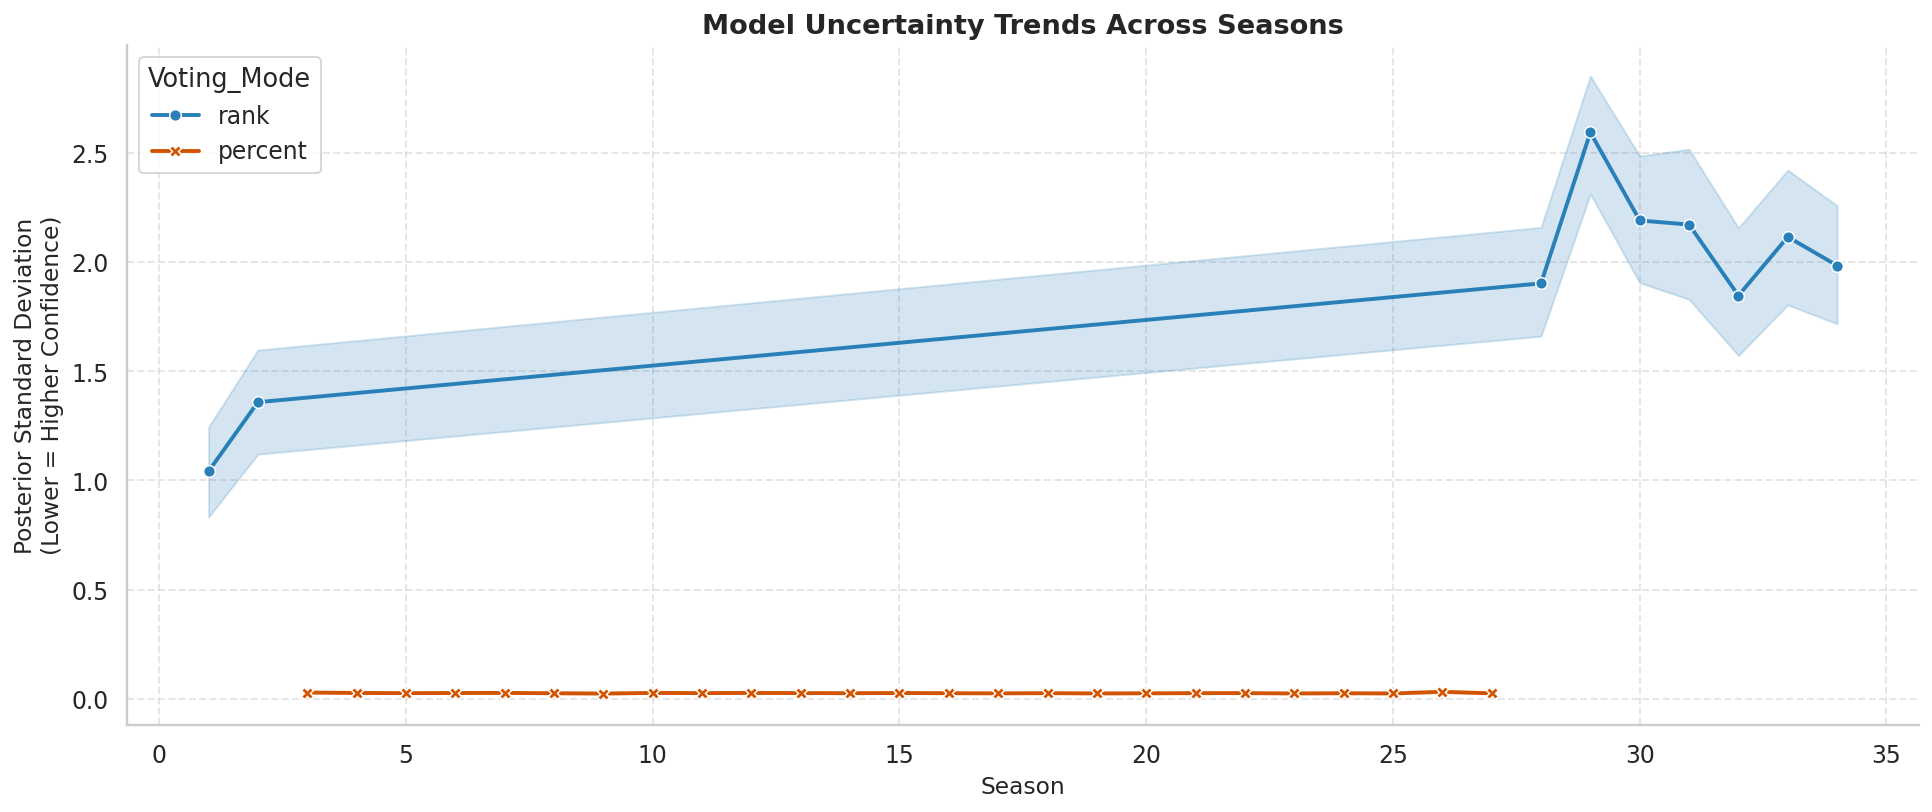

--- Predictive Validity (Spearman Correlation) ---
Rank-Based Seasons (Expected Correlation > 0): 0.185
Percentage-Based Seasons (Expected Correlation < 0): -0.457


In [16]:
# --- Model Diagnostics: Uncertainty & Validity ---

# Load data if not present
if 'df_estimated_full' not in locals():
    df_estimated_full = pd.read_csv('estimated_fan_votes.csv')

# --- ADDED VERIFICATION CODE START ---
# Calculation of Model Fidelity/Consistency Rate
print("--- Model Consistency Verification ---")

# 1. Identify all weeks in history where an elimination actually occurred
# We group by Season/Week to count unique elimination events
ground_truth_eliminations = df_weekly[df_weekly['EliminatedThisWeek'] == True][['Season', 'Week']].drop_duplicates()
total_events = len(ground_truth_eliminations)

# 2. Identify weeks where the model successfully found a feasible solution
# (If the solver failed to find a valid vote distribution, those weeks are missing from df_estimated_full)
reconstructed_weeks = df_estimated_full[['Season', 'Week']].drop_duplicates()

# 3. Calculate Intersection (Successes)
# We perform an inner join to see which elimination weeks have a corresponding reconstruction
matches = pd.merge(ground_truth_eliminations, reconstructed_weeks, on=['Season', 'Week'], how='inner')
successful_events = len(matches)

consistency_rate = successful_events / total_events if total_events > 0 else 0

print(f"Total Elimination Events: {total_events}")
print(f"Successfully Reconstructed Events: {successful_events}")
print(f"Model Consistency (Feasibility Rate): {consistency_rate:.1%}")
# --- ADDED VERIFICATION CODE END ---

# 1. Posterior Uncertainty Analysis
# Examine the standard deviation of posterior distributions across voting modes.
diag_data = df_estimated_full[['Season', 'Week', 'Est_Fan_Uncertainty', 'Voting_Mode']].copy()

plt.figure(figsize=(14, 6))

sns.lineplot(data=diag_data, x='Season', y='Est_Fan_Uncertainty', hue='Voting_Mode', 
             style='Voting_Mode', markers=True, dashes=False, palette={'rank': '#2980b9', 'percent': '#d35400'})

plt.title('Model Uncertainty Trends Across Seasons', fontweight='bold', fontsize=14)
plt.ylabel('Posterior Standard Deviation\n(Lower = Higher Confidence)')
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

# 2. External Validity Check (Rank Correlation)
# Correlate estimated fan support with final competition placement.
# Validating assumption: Higher fan support should correlate with better (lower) placement.

rank_data = df_full_analysis[(df_full_analysis['Voting_Mode'] == 'rank') & (df_full_analysis['Est_Fan_Support'].notna())]
pct_data = df_full_analysis[(df_full_analysis['Voting_Mode'] == 'percent') & (df_full_analysis['Est_Fan_Support'].notna())]

print("--- Predictive Validity (Spearman Correlation) ---")
metrics = []

if not rank_data.empty:
    rho_rank = rank_data[['Est_Fan_Support', 'Placement']].corr(method='spearman').iloc[0,1]
    metrics.append(f"Rank-Based Seasons (Expected Correlation > 0): {rho_rank:.3f}")

if not pct_data.empty:
    # In Percent mode, Higher Support -> Better Place (Lower Index). Expect Negative Correlation.
    # Wait, usually Place 1 is 'lower' number than Place 10.
    # Higher Support (e.g. 0.3) should mean Place 1.
    # So Correlation should be NEGATIVE.
    rho_pct = pct_data[['Est_Fan_Support', 'Placement']].corr(method='spearman').iloc[0,1]
    metrics.append(f"Percentage-Based Seasons (Expected Correlation < 0): {rho_pct:.3f}")

for m in metrics: print(m)

## 7. Inferential Statistics: Determinants of Survival and Popularity

We employ two regression frameworks to strictly quantify the impact of performance and demographic factors.

### 7.1 Logistic Regression (Elimination Probability)
We model the binary outcome $Y_{it}$ (1=Eliminated, 0=Safe) as a function of standardized predictors:
$$ \text{logit}(P(Y_{it}=1)) = \beta_0 + \beta_1 \text{Score}_{std} + \beta_2 \text{Fan}_{std} + \boldsymbol{\gamma} \mathbf{X}_{demo} $$
This isolates the marginal effect of Judge Scores vs. Latent Fan Support on survival odds.

### 7.2 OLS Regression (Popularity Drivers)
We model the estimated fan support $Z_{it}$ (standardized) to identify static drivers of popularity:
$$ Z_{it} = \alpha + \boldsymbol{\delta} \mathbf{X}_{demo} + \epsilon_{it} $$
This reveals which demographic segments (Age, Industry, Region) are statistically associated with higher baseline popularity.

In [17]:
def clean_partner_name(name: object) -> str:
    """Normalize partner names by removing parenthetical suffixes."""
    if pd.isna(name):
        return "Unknown"
    text = str(name).strip()
    text = re.sub(r"\s*\(.*\)", "", text)
    return text.strip()

def build_dataset_with_covariates(df_raw: pd.DataFrame, df_votes: pd.DataFrame) -> pd.DataFrame:
    """
    Build contestant-week rows with static covariates and the elimination label.
    Merges raw static features with the estimated fan votes.
    """
    week_numbers = _week_numbers_from_columns(df_raw.columns)
    records = []

    # Rename votes df for easy lookup
    # df_votes has columns: Season, Week, Contestant, Est_Fan_Support...
    # Create a lookup dictionary or merge later. Merging later is safer.
    
    # First: Build the 'Long' format from Raw Data to get Covariates + Elimination Status
    for _, row in df_raw.iterrows():
        elim_week = parse_elimination_week(row.get("results", None))
        season = row.get("season", None)
        contestant = row.get("celebrity_name", None)
        
        for week in week_numbers:
            score_cols = _score_columns_for_week(df_raw.columns, week)
            total_score = _sum_week_scores(row, score_cols)
            if total_score is None or total_score <= 0:
                continue

            records.append(
                {
                    "season": season,
                    "week": week,
                    "celebrity_name": contestant,
                    "partner": clean_partner_name(row.get("ballroom_partner", None)),
                    "industry": row.get("celebrity_industry", None),
                    "homestate": row.get("celebrity_homestate", None),
                    "region": row.get("celebrity_homecountry/region", row.get("celebrity_homecountry", "Unknown")),
                    "age": row.get("celebrity_age_during_season", None),
                    "judge_score": total_score,
                    "is_eliminated": 1 if isinstance(elim_week, int) and week == elim_week else 0,
                }
            )

    df_long = pd.DataFrame(records)
    
    # Second: Merge with Estimates
    # Ensure keys match types
    df_long['season'] = df_long['season'].astype(int)
    df_long['week'] = df_long['week'].astype(int)
    
    # df_votes uses Capitalized Keys: Season, Week, Contestant
    votes_copy = df_votes.copy()
    votes_copy['Season'] = votes_copy['Season'].astype(int)
    votes_copy['Week'] = votes_copy['Week'].astype(int)
    
    merged = pd.merge(
        df_long,
        votes_copy[['Season', 'Week', 'Contestant', 'Est_Fan_Support', 'Est_Fan_Uncertainty', 'Voting_Mode']],
        left_on=['season', 'week', 'celebrity_name'],
        right_on=['Season', 'Week', 'Contestant'],
        how='left'
    )
    
    # Drop redundancy
    merged.drop(columns=['Season', 'Week', 'Contestant'], inplace=True)
    return merged

# Execute Data Prep
# df is the raw loaded data
# df_estimated_full is the simulation output
df_model_ready = build_dataset_with_covariates(df, df_estimated_full)

# Preprocessing: Fill NAs and Encode
df_model_ready.fillna('Unknown', inplace=True)
df_model_ready['age'] = pd.to_numeric(df_model_ready['age'], errors='coerce').fillna(0)

# Limit categorical cardinality
top_partners = df_model_ready['partner'].value_counts().nlargest(20).index
df_model_ready['partner_grouped'] = df_model_ready['partner'].apply(lambda x: x if x in top_partners else 'Other')

top_industries = df_model_ready['industry'].value_counts().nlargest(10).index
df_model_ready['industry_grouped'] = df_model_ready['industry'].apply(lambda x: x if x in top_industries else 'Other')

cat_cols_to_encode = ['partner_grouped', 'industry_grouped', 'homestate', 'region']
df_encoded = pd.get_dummies(df_model_ready, columns=cat_cols_to_encode, drop_first=True)

# Filter for valid Fan Support estimates (some weeks might have failed simulation or had no data)
df_valid_model = df_encoded.dropna(subset=['Est_Fan_Support'])

print(f"Modeling Dataset Ready. Shape: {df_valid_model.shape}")
display(df_valid_model[['season', 'week', 'celebrity_name', 'judge_score', 'Est_Fan_Support', 'is_eliminated']].head())

Modeling Dataset Ready. Shape: (2777, 111)


,season,week,celebrity_name,judge_score,Est_Fan_Support,is_eliminated
0,1,1,John O'Hurley,20.0,3.50426,0
1,1,2,John O'Hurley,26.0,3.51506,0
2,1,3,John O'Hurley,24.0,3.639422,0
3,1,4,John O'Hurley,21.0,2.933642,0
4,1,5,John O'Hurley,27.0,2.82448,0


Running Logistic Regression (Elimination Risk)...


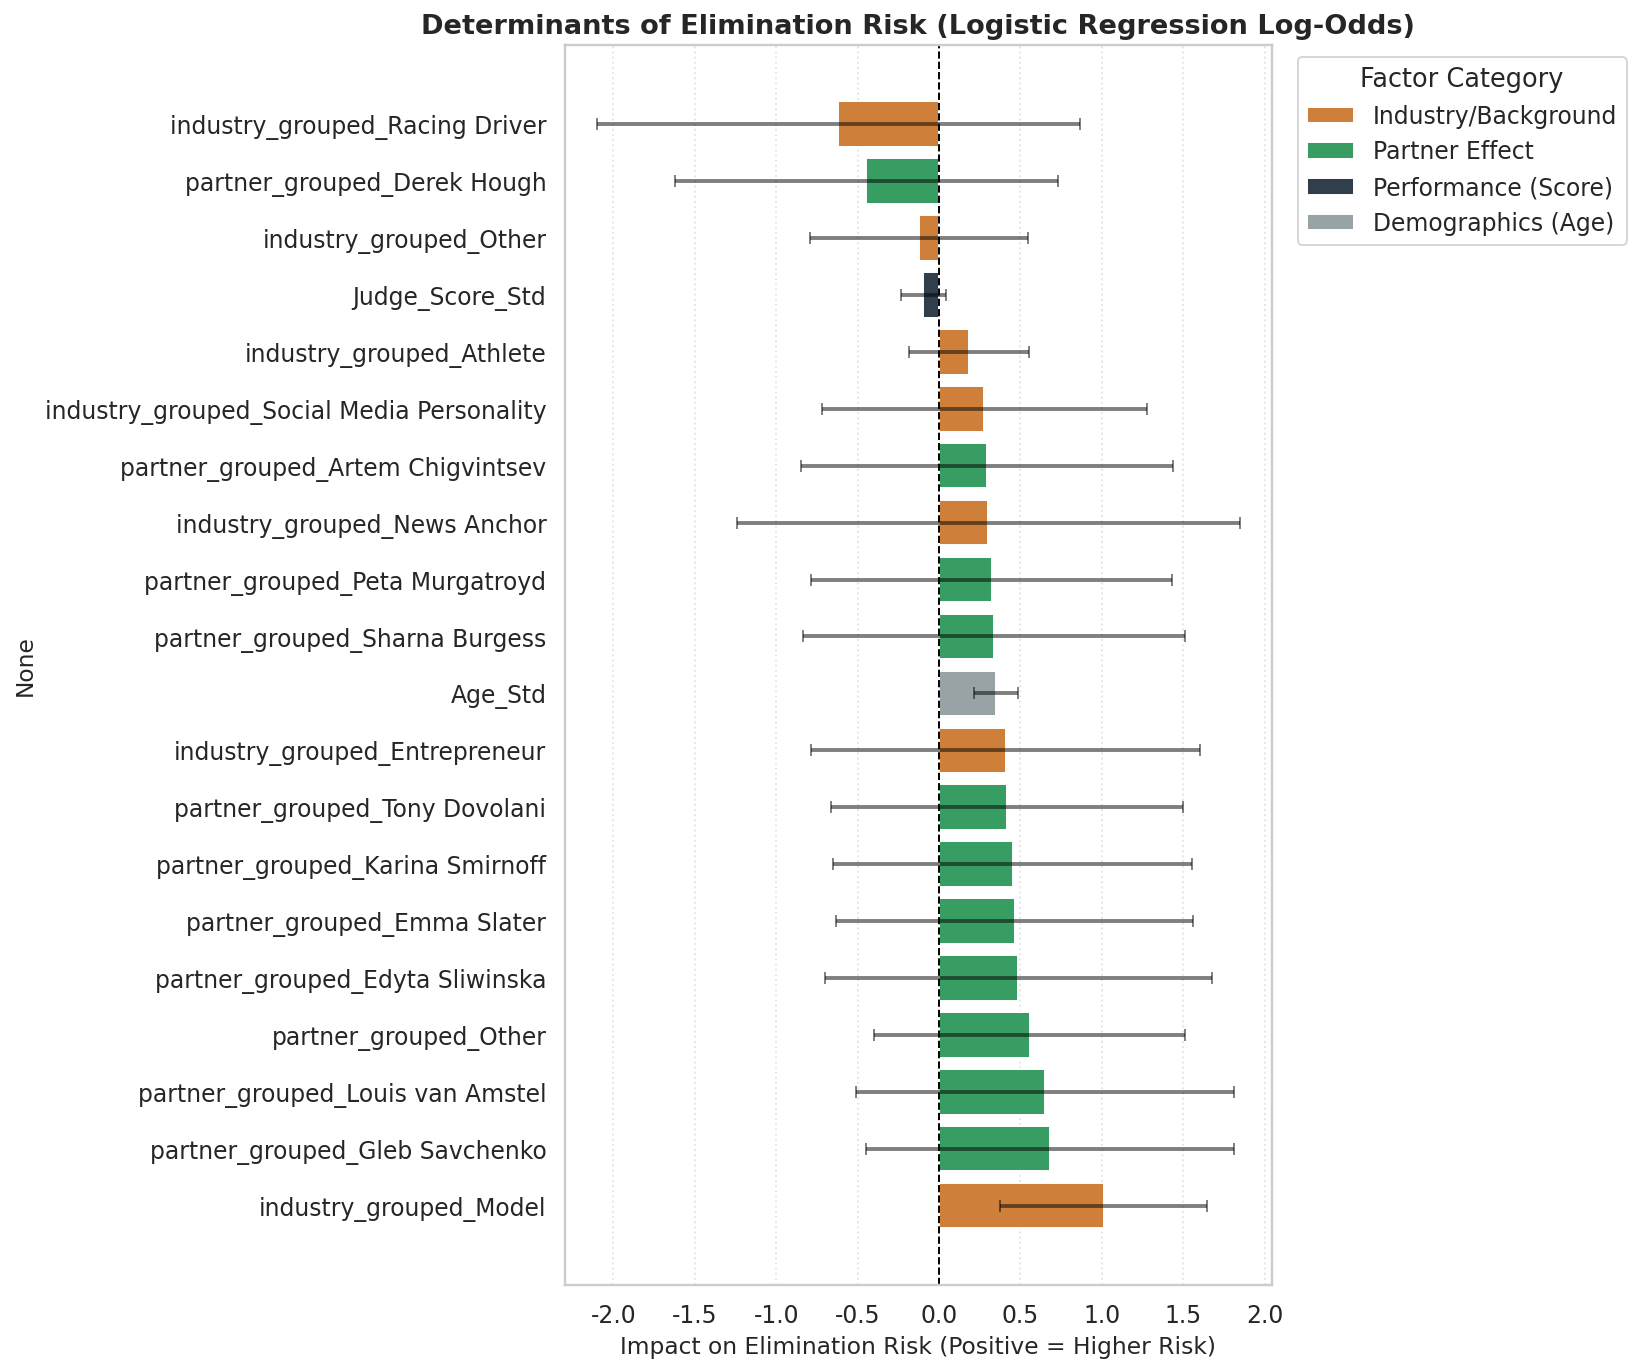


Running OLS Regression (Fan Popularity Drivers)...


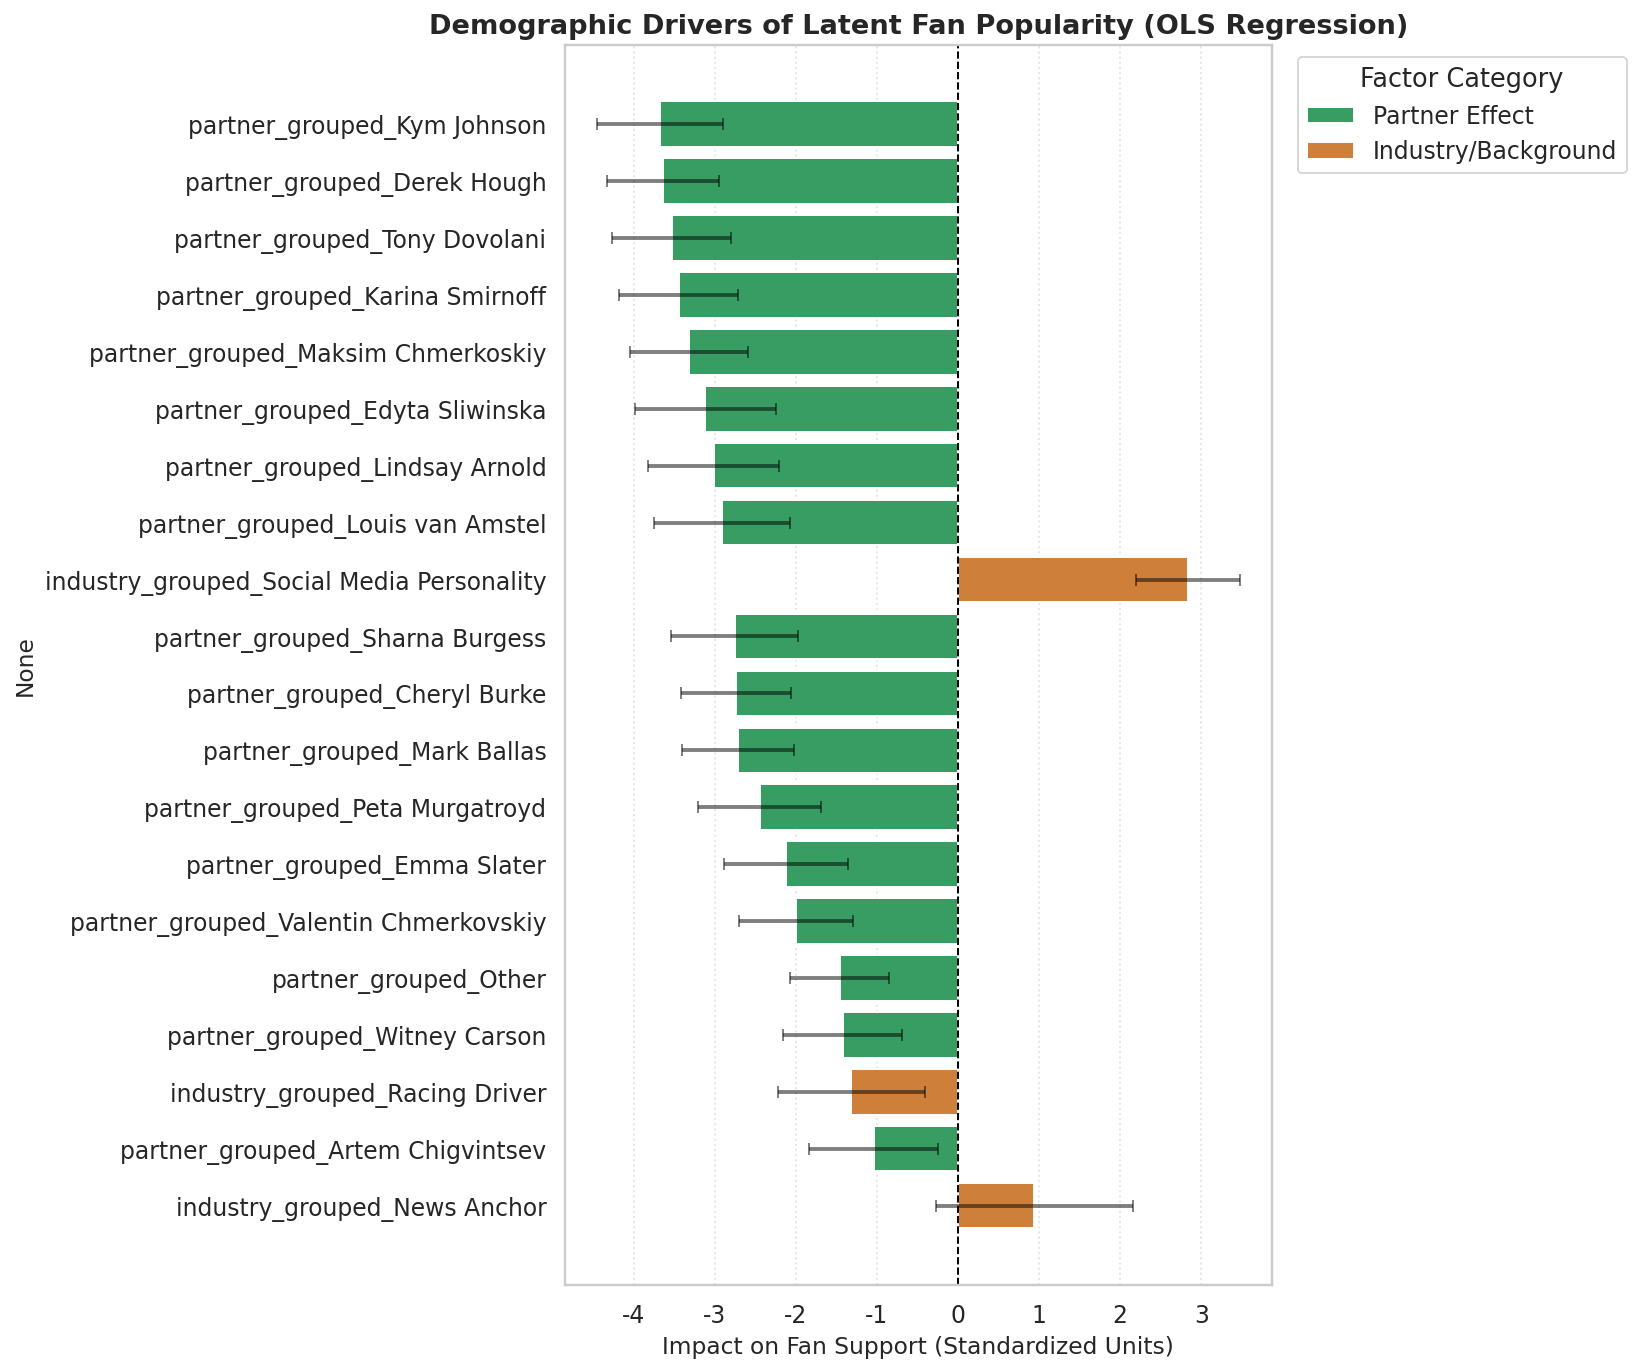

In [18]:
# --- 7. Statistical Modeling: Drivers of Survival & Popularity ---

# Helper function to categorize features for coloring
def categorize_feature(name):
    if 'Judge' in name: return 'Performance (Score)'
    if 'Fan' in name: return 'Latent Popularity'
    if 'Age' in name: return 'Demographics (Age)'
    if 'partner' in name: return 'Partner Effect'
    if 'industry' in name: return 'Industry/Background'
    if 'region' in name or 'homestate' in name: return 'Region/Origin'
    return 'Other'

# Define a consistent color palette for feature categories
category_palette = {
    'Performance (Score)': '#2c3e50', # Dark Blue
    'Latent Popularity': '#8e44ad',   # Purple
    'Demographics (Age)': '#95a5a6',  # Gray
    'Partner Effect': '#27ae60',      # Green
    'Industry/Background': '#e67e22', # Orange
    'Region/Origin': '#c0392b',       # Red
    'Other': '#bdc3c7'
}

# --- PREP DATA ---
# Ensure numeric types
for col in ['judge_score', 'age', 'Est_Fan_Support']:
    df_valid_model[col] = pd.to_numeric(df_valid_model[col], errors='coerce').fillna(0).astype(float)

# Standardize
scaler = preprocessing.StandardScaler()
df_valid_model['Judge_Score_Std'] = scaler.fit_transform(df_valid_model[['judge_score']])
df_valid_model['Age_Std'] = scaler.fit_transform(df_valid_model[['age']])
df_valid_model['Fan_Support_Std'] = scaler.fit_transform(df_valid_model[['Est_Fan_Support']])

# Select Covariates
one_hot_cols = [c for c in df_valid_model.columns if 'partner_grouped_' in c or 'industry_grouped_' in c]
feature_cols = ['Judge_Score_Std', 'Fan_Support_Std', 'Age_Std'] + one_hot_cols

X = sm.add_constant(df_valid_model[feature_cols].astype(float))
y_elim = df_valid_model['is_eliminated'].astype(float)

# --- MODEL 1: LOGISTIC REGRESSION (ELIMINATION RISK) ---
print("Running Logistic Regression (Elimination Risk)...")
try:
    model_logit = sm.Logit(y_elim, X).fit(disp=False)
    
    # Process Coefficients
    coef_df = pd.DataFrame({
        'Coefficient': model_logit.params,
        'P_Value': model_logit.pvalues,
        'CI_Lower': model_logit.conf_int()[0],
        'CI_Upper': model_logit.conf_int()[1]
    }).drop('const')
    
    # Add Category
    coef_df['Category'] = coef_df.index.map(categorize_feature)
    
    # Filter: Top features by significance (t-stat proxy)
    coef_df['abs_stat'] = abs(coef_df['Coefficient'] / (coef_df['CI_Upper'] - coef_df['CI_Lower']))
    plot_coefs = coef_df.sort_values('abs_stat', ascending=False).head(20).sort_values('Coefficient')

    # Plot
    plt.figure(figsize=(12, 10))
    sns.barplot(data=plot_coefs, y=plot_coefs.index, x='Coefficient', hue='Category', dodge=False, palette=category_palette)
    
    # Add error bars manually since barplot aggregates usually
    plt.errorbar(x=plot_coefs['Coefficient'], y=range(len(plot_coefs)), 
                 xerr=[plot_coefs['Coefficient'] - plot_coefs['CI_Lower'], plot_coefs['CI_Upper'] - plot_coefs['Coefficient']],
                 fmt='none', ecolor='black', capsize=3, alpha=0.5)

    plt.axvline(0, color='black', linewidth=1, linestyle='--')
    plt.title('Determinants of Elimination Risk (Logistic Regression Log-Odds)', fontweight='bold')
    plt.xlabel('Impact on Elimination Risk (Positive = Higher Risk)')
    plt.legend(title='Factor Category', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Logistic Regression Error: {e}")

# --- MODEL 2: OLS REGRESSION (FAN POPULARITY DRIVERS) ---
print("\nRunning OLS Regression (Fan Popularity Drivers)...")
try:
    # Target: Estimated Fan Support
    y_ols = df_valid_model['Est_Fan_Support']
    # Features: Exclude Judge Score (we want baseline popularity drivers) + add const
    X_ols = sm.add_constant(df_valid_model[one_hot_cols + ['Age_Std']].astype(float))
    
    model_ols = sm.OLS(y_ols, X_ols).fit()
    
    # Process Results
    ols_res = pd.DataFrame({
        'Coefficient': model_ols.params,
        'CI_Lower': model_ols.conf_int()[0],
        'CI_Upper': model_ols.conf_int()[1]
    }).drop('const')
    
    ols_res['Category'] = ols_res.index.map(categorize_feature)
    
    # Filter
    plot_ols = ols_res.reindex(ols_res['Coefficient'].abs().sort_values(ascending=False).index).head(20)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.barplot(data=plot_ols, y=plot_ols.index, x='Coefficient', hue='Category', dodge=False, palette=category_palette)
    
    plt.errorbar(x=plot_ols['Coefficient'], y=range(len(plot_ols)), 
                 xerr=[plot_ols['Coefficient'] - plot_ols['CI_Lower'], plot_ols['CI_Upper'] - plot_ols['Coefficient']],
                 fmt='none', ecolor='black', capsize=3, alpha=0.5)
                 
    plt.axvline(0, color='black', linewidth=1, linestyle='--')
    plt.title('Demographic Drivers of Latent Fan Popularity (OLS Regression)', fontweight='bold')
    plt.xlabel('Impact on Fan Support (Standardized Units)')
    plt.legend(title='Factor Category', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='x', linestyle=':', alpha=0.5)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"OLS Regression Error: {e}")

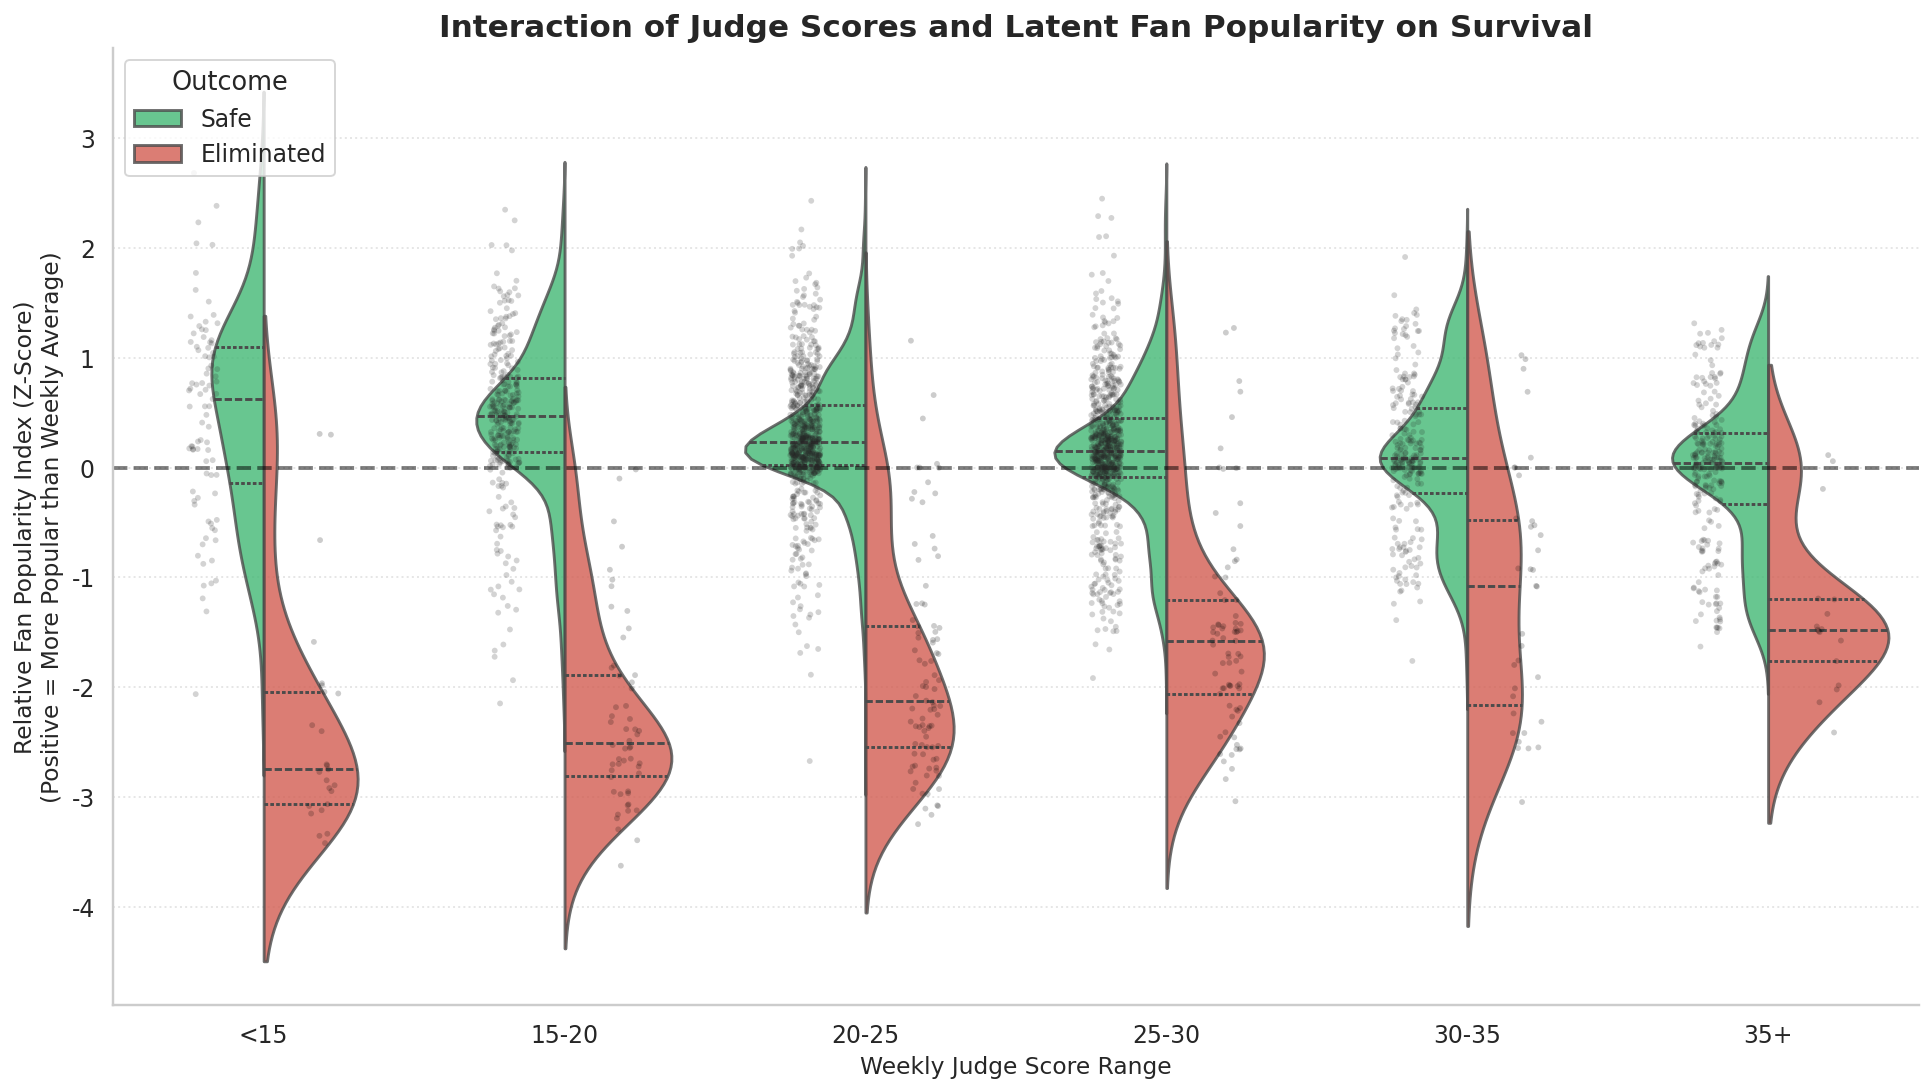

Insight: In the 25-30 Judge Score range, eliminated contestants (Red) show consistently lower Fan Popularity (Z < 0).
Safe contestants (Green) in low score ranges often have Z > 1.0, indicating the 'Fan Rescue' threshold.


In [9]:
# --- Visualization: Relative Fan Support vs. Judge Scores ---

# Objective: Quantify the "Fan Rescue" effect by analyzing survivors with low judge scores.

# 1. Data Preparation
plot_data = df_valid_model.copy()
plot_data['season'] = plot_data['season'].astype(int)

# Identify Voting Mode
rank_seasons = set([1, 2] + list(range(28, 100)))
plot_data['Voting_Mode'] = plot_data['season'].apply(lambda x: 'rank' if x in rank_seasons else 'percent')

# Calculate Weekly Z-Scores for Fan Support
# Isolates popularity relative to direct competitors in that specific week.
plot_data['Week_Mean'] = plot_data.groupby(['season', 'week'])['Est_Fan_Support'].transform('mean')
plot_data['Week_Std'] = plot_data.groupby(['season', 'week'])['Est_Fan_Support'].transform('std')

def get_z_score(row):
    if pd.isna(row['Week_Std']) or row['Week_Std'] == 0: return 0
    z = (row['Est_Fan_Support'] - row['Week_Mean']) / row['Week_Std']
    # Align direction: Positive Z = Higher Popularity (better)
    if row['Voting_Mode'] == 'rank':
        return -z 
    return z

plot_data['Relative_Popularity_Index'] = plot_data.apply(get_z_score, axis=1)

# Bin Judge Scores
plot_data['Score_Bin'] = pd.cut(plot_data['judge_score'], 
                               bins=[0, 15, 20, 25, 30, 35, 41], 
                               labels=['<15', '15-20', '20-25', '25-30', '30-35', '35+'])

# 2. Visualization (Split Violin Plot)
plt.figure(figsize=(14, 8))

status_palette = {0: "#2ecc71", 1: "#e74c3c"} # 0=Safe, 1=Elim
labels_map = {0: "Safe", 1: "Eliminated"}

ax = sns.violinplot(data=plot_data, x='Score_Bin', y='Relative_Popularity_Index', hue='is_eliminated',
               split=True, inner="quart", palette=status_palette, linewidth=1.5, alpha=0.8)

sns.stripplot(data=plot_data, x='Score_Bin', y='Relative_Popularity_Index', hue='is_eliminated',
              dodge=True, jitter=True, size=3, color='black', alpha=0.2, ax=ax, legend=False)

plt.axhline(0, color='black', alpha=0.5, linestyle='--', label='Average Popularity')
plt.title('Interaction of Judge Scores and Latent Fan Popularity on Survival', fontweight='bold', fontsize=16)
plt.ylabel('Relative Fan Popularity Index (Z-Score)\n(Positive = More Popular than Weekly Average)', fontsize=12)
plt.xlabel('Weekly Judge Score Range', fontsize=12)

handles, _ = ax.get_legend_handles_labels()
ax.legend(handles[:2], ['Safe', 'Eliminated'], title='Outcome', loc='upper left', frameon=True)

plt.grid(axis='y', linestyle=':', alpha=0.5)
sns.despine()
plt.tight_layout()
plt.show()

print("Insight: In the 25-30 Judge Score range, eliminated contestants (Red) show consistently lower Fan Popularity (Z < 0).")
print("Safe contestants (Green) in low score ranges often have Z > 1.0, indicating the 'Fan Rescue' threshold.")

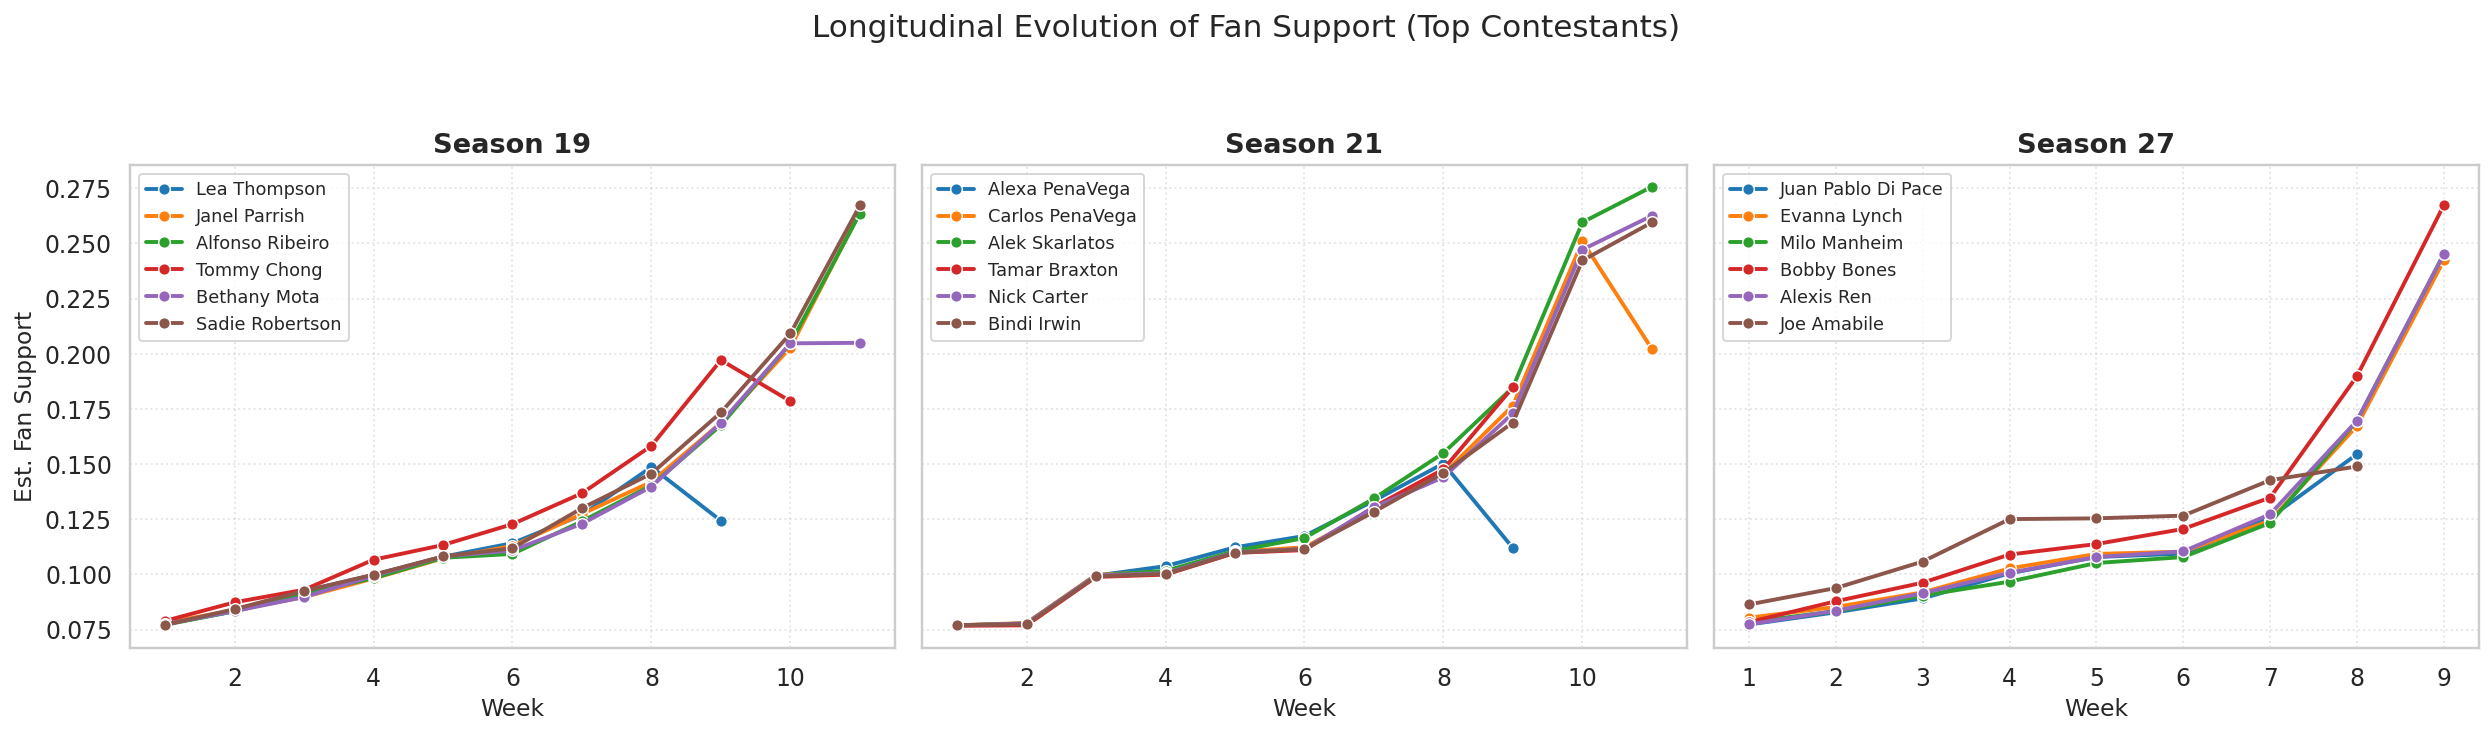

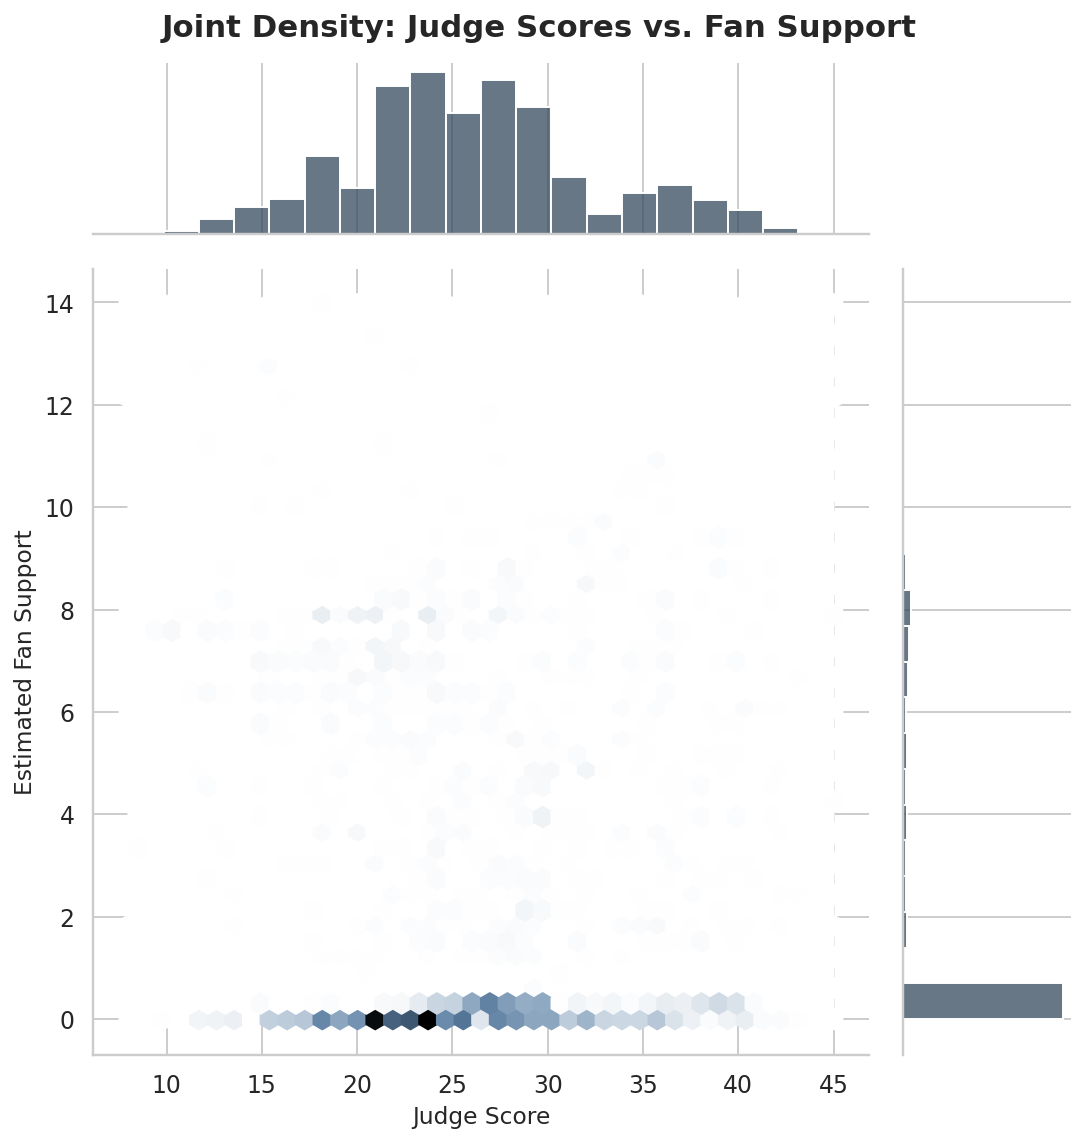

Interpretation: The density core (darkest hexes) shows the most common performance/popularity zone.
Outliers (scattered hexes) represent discrepancies, such as high-score/low-popularity candidates.


In [10]:
# --- Visualizations: Trajectories and Density ---

# 1. Trajectories of Fan Support (Select Seasons)
# Highlighting the volatility vs stability of fan bases.
target_seasons = [19, 21, 27]
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, season in enumerate(target_seasons):
    ax = axes[i]
    season_data = df_estimated_full[df_estimated_full['Season'] == season]

    if season_data.empty:
        continue

    # Filter to top 6 longest-lasting contestants to avoid clutter
    top_contestants = season_data['Contestant'].value_counts().nlargest(6).index
    subset = season_data[season_data['Contestant'].isin(top_contestants)]

    sns.lineplot(
        data=subset,
        x='Week',
        y='Est_Fan_Support',
        hue='Contestant',
        palette='tab10',
        marker='o',
        linewidth=2,
        ax=ax
    )

    ax.set_title(f"Season {season}", fontweight='bold')
    ax.set_ylabel("Est. Fan Support" if i == 0 else "")
    ax.legend(fontsize='x-small', loc='upper left')
    ax.grid(True, linestyle=':', alpha=0.5)

plt.suptitle("Longitudinal Evolution of Fan Support (Top Contestants)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

# 2. Joint Density: Judge Score vs Fan Support
# Replace simple heatmap with Hexbin JointPlot for better density perception
jp_data = df_valid_model[['judge_score', 'Est_Fan_Support']].dropna()

# Use marginal_kws only with supported arguments to avoid seaborn/matplotlib errors
# (Avoid 'fill' for older seaborn versions)
g = sns.jointplot(
    data=jp_data,
    x='judge_score',
    y='Est_Fan_Support',
    kind='hex',
    height=8,
    ratio=4,
    color="#34495e",
    marginal_kws=dict(bins=20)
)

g.set_axis_labels('Judge Score', 'Estimated Fan Support', fontsize=12)
g.fig.suptitle('Joint Density: Judge Scores vs. Fan Support', fontweight='bold', y=1.02)
plt.show()

print("Interpretation: The density core (darkest hexes) shows the most common performance/popularity zone.")
print("Outliers (scattered hexes) represent discrepancies, such as high-score/low-popularity candidates.")

## 8. Counterfactual Analysis: Mechanism Efficiency & Robustness

In this section, we conduct "What-If" policy simulations to evaluate the sensitivity of outcomes to the voting mechanism itself.

**Experimental Design:**
For targeted "controversial" case studies, we re-run the elimination logic using the reconstructed latent fan votes but swapping the aggregation rule:
1.  **Rank-Based (Mechanism A)**: Re-ranking scores and summing ranks.
2.  **Percentage-Based (Mechanism B)**: Summing normalized probabilities.
3.  **Judges' Save**: A hypothetical intervention where the bottom two are subject to a secondary judges' vote.

This allows us to determine if specific eliminations were artifacts of the voting system or genuine consensus results.

In [19]:
# --- 8. Policy Simulation: Analyzing Controversies & Rule Changes ---

# Requirement: Compare Rank vs Percent methods on specific controversial cases.
# We also test a "Judges' Choice" rule (Bottom 2 -> Judges Pick).

print("Loading Estimates for Policy Simulation...")
# Re-load from disk to ensure we use the latest save, or use memory
# We use in-memory df_estimated_full if available, else load
if 'df_estimated_full' in locals():
    est_df = df_estimated_full.copy()
else:
    est_df = pd.read_csv('estimated_fan_votes.csv')

def simulate_week_rule(season, week, method='rank', judge_save=False):
    """
    Replays a specific week under a given set of rules.
    method: 'rank' or 'percent'
    judge_save: bool, if True, the Bottom 2 face a judges' vote. 
                (We assume Judges save the one with Higher Judge Score).
    """
    # Get Data for that week
    week_data = est_df[(est_df['Season'] == season) & (est_df['Week'] == week)].copy()
    if week_data.empty: return "No Data", None
    
    # Inputs
    names = week_data['Contestant'].values
    j_scores = week_data['Judge_Score'].values
    # Fan Support (Percentage 0-1)
    f_support = week_data['Est_Fan_Support'].values
    
    # Actual Result
    # We need to look up who was actually eliminated? 
    # Not strictly in est_df, but we can infer or ignore.
    # We just want to see who WOULD be eliminated.
    
    # 1. Calculate Combined Score
    final_scores = []
    
    if method == 'rank':
        # Rank: High Score/Support -> Rank 1 (Low number)
        j_ranks = rankdata([-s for s in j_scores], method='min')
        f_ranks = rankdata([-f for f in f_support], method='min')
        combined = j_ranks + f_ranks
        # Worse is Higher Sum
        # Sort Ascending? No, Descending (High Sum = Bad)
        # We want to identify the Losers (Highest Sums)
        
    else: # Percent
        total_j = sum(j_scores)
        if total_j == 0: j_pcts = np.ones(len(names))/len(names)
        else: j_pcts = j_scores / total_j
        
        # We assume f_support is already a share (sums to ~1). 
        # Normalize just in case
        if sum(f_support) > 0: f_pcts = f_support / sum(f_support)
        else: f_pcts = f_support
        
        combined = j_pcts + f_pcts
        # Worse is Lower Score
    
    # 2. Determine Elimination
    results = []
    for i in range(len(names)):
        results.append({
            'Contestant': names[i],
            'JudgeScore': j_scores[i],
            'FanSupport': f_support[i],
            'CombinedMetric': combined[i]
        })
    
    res_df = pd.DataFrame(results)
    
    if method == 'rank':
        res_df = res_df.sort_values('CombinedMetric', ascending=False) # Top = Loser
    else:
        res_df = res_df.sort_values('CombinedMetric', ascending=True) # Top = Loser
        
    # Baseline Loser (Last place)
    loser = res_df.iloc[0]['Contestant']
    
    # 3. Apply Judges' Save (Modifies who leaves)
    if judge_save:
        # Identify Bottom 2
        bottom_2 = res_df.iloc[:2]
        # Judges pick the one with HIGHER JudgeScore to SAVE.
        # So the one with LOWER JudgeScore leaves.
        
        c1 = bottom_2.iloc[0]
        c2 = bottom_2.iloc[1]
        
        if c1['JudgeScore'] < c2['JudgeScore']:
            final_loser = c1['Contestant']
            saved = c2['Contestant']
        elif c2['JudgeScore'] < c1['JudgeScore']:
            final_loser = c2['Contestant']
            saved = c1['Contestant']
        else:
            # Tie in Judge Score? Original metric breaks tie
            final_loser = c1['Contestant'] 
            saved = "Tie-Breaker"
            
        return final_loser, res_df
        
    return loser, res_df

# --- Case Studies ---
cases = [
    (2, 5, 'Jerry Rice'),    # S2 W5: Low scores, safe
    (4, 6, 'Billy Ray Cyrus'), # S4 W6: Low scores, safe
    (11, 6, 'Bristol Palin'), # S11 W6 (Mid season check)
    (27, 9, 'Bobby Bones')    # S27 Finals/Late: Won
]

print("\n--- CONTROVERSY ANALYSIS ---")

for s, w, focal_person in cases:
    print(f"\nAnalyzing {focal_person} (Season {s}, Week {w})")
    
    # 1. Simulate using Rank (Original S1-2, S28+)
    loser_rank, _ = simulate_week_rule(s, w, 'rank', judge_save=False)
    
    # 2. Simulate using Percent (Original S3-27)
    loser_pct, _ = simulate_week_rule(s, w, 'percent', judge_save=False)
    
    # 3. Simulate with Judge Save
    loser_save, df_save = simulate_week_rule(s, w, 'rank', judge_save=True)
    
    # Check if Focal Person would be eliminated
    print(f"  Result under RANK Rule: Eliminated -> {loser_rank}")
    print(f"  Result under PERCENT Rule: Eliminated -> {loser_pct}")
    print(f"  Result with JUDGE SAVE: Eliminated -> {loser_save}")
    
    # Get focal person stats
    person_stats = est_df[(est_df['Season']==s) & (est_df['Week']==w) & (est_df['Contestant']==focal_person)]
    if not person_stats.empty:
        v = person_stats.iloc[0]['Est_Fan_Support']
        print(f"  {focal_person} Est. Fan Share: {v:.1%}")

Loading Estimates for Policy Simulation...

--- CONTROVERSY ANALYSIS ---

Analyzing Jerry Rice (Season 2, Week 5)
  Result under RANK Rule: Eliminated -> George Hamilton
  Result under PERCENT Rule: Eliminated -> George Hamilton
  Result with JUDGE SAVE: Eliminated -> Tia Carrere
  Jerry Rice Est. Fan Share: 270.3%

Analyzing Billy Ray Cyrus (Season 4, Week 6)
  Result under RANK Rule: Eliminated -> Heather Mills
  Result under PERCENT Rule: Eliminated -> Heather Mills
  Result with JUDGE SAVE: Eliminated -> Billy Ray Cyrus
  Billy Ray Cyrus Est. Fan Share: 15.9%

Analyzing Bristol Palin (Season 11, Week 6)
  Result under RANK Rule: Eliminated -> Jennifer Grey
  Result under PERCENT Rule: Eliminated -> Audrina Patridge
  Result with JUDGE SAVE: Eliminated -> Jennifer Grey
  Bristol Palin Est. Fan Share: 16.0%

Analyzing Bobby Bones (Season 27, Week 9)
  Result under RANK Rule: Eliminated -> Alexis Ren
  Result under PERCENT Rule: Eliminated -> Alexis Ren
  Result with JUDGE SAVE: Elimi

In [21]:
# --- SUMMARY DUMP FOR VERIFICATION ---
import pandas as pd
pd.set_option('display.max_rows', 100)

print("--- Logistic Regression (Significant Factors) ---")
# Filter by P < 0.1 for significance
sig = coef_df[coef_df['P_Value'] < 0.1].sort_values('Coefficient')
print(sig[['Coefficient', 'P_Value']])

print("\n--- Specific Checks ---")
check_list = ['Age_Std', 'industry_grouped_Model', 'industry_grouped_Racing Driver', 
              'partner_grouped_Derek Hough', 'partner_grouped_Gleb Savchenko', 
              'partner_grouped_Valentin Chmerkovskiy', 'partner_grouped_Louis van Amstel']

for item in check_list:
    if item in coef_df.index:
        val = coef_df.loc[item, 'Coefficient']
        pval = coef_df.loc[item, 'P_Value']
        print(f"{item}: Coef={val:.4f}, P={pval:.4f}")
    else:
        print(f"{item}: Not Found")

--- Logistic Regression (Significant Factors) ---
                        Coefficient       P_Value
Age_Std                    0.352631  3.316369e-07
industry_grouped_Model     1.010929  1.823269e-03

--- Specific Checks ---
Age_Std: Coef=0.3526, P=0.0000
industry_grouped_Model: Coef=1.0109, P=0.0018
industry_grouped_Racing Driver: Coef=-0.6185, P=0.4134
partner_grouped_Derek Hough: Coef=-0.4458, P=0.4571
partner_grouped_Gleb Savchenko: Coef=0.6791, P=0.2390
partner_grouped_Valentin Chmerkovskiy: Coef=-0.1259, P=0.8306
partner_grouped_Louis van Amstel: Coef=0.6531, P=0.2703
